In [1]:
# Imports

# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatPlotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingRegressor

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor


# Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Set the default transformation output to Pandas
from sklearn import set_config
set_config(transform_output='pandas')
set_config(display='diagram') # 'text' or 'diagram'}
from IPython.core.display import clear_output

C:\Users\arvin\AppData\Local\Temp\ipykernel_11920\1828839483.py:39: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [2]:
def eval_regression(true, pred, name='Model'):

    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name='Model'):

    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [3]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(pipe, X_train, y_train, X_test, y_test,
                       model_name='Regression Model'):

  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  # Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  metrics = ['train_MAE','test_MAE',
             'train_RMSE', 'test_RMSE',
             'train_R2', 'test_R2']

  # Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  # Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  # Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[model_name])
  scores.loc[model_name, :] = [train_mae, test_mae,
                              train_rmse, test_rmse,
                              train_r2, test_r2]
  return scores

In [4]:
def explore_numeric(df, x, figsize=(6,5) ):

  # Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100

  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  # Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  # Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [5]:
def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):

  """Helper Function
  This custom function accept true targets and predictions with custom label
  Calculate and print  MAE, MSE , RMSE and R2 scores by saving it in a dictionary"""

  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics including MAE, MSE, RMSE, and R-squared.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: A dictionary containing regression metrics.
    """
    metrics = {}

    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['R2'] = r2_score(y_true, y_pred)

    return metrics

In [7]:
# Set MatPlotLib default parameters

plt.rcParams.update({'figure.facecolor': 'white',
                          'font.weight': 'bold',
                      'patch.linewidth': 1.25,
                       'axes.facecolor': 'white',
                       'axes.edgecolor': 'black',
                       'axes.linewidth': 2,
                       'axes.titlesize': 14,
                     'axes.titleweight': 'bold',
                       'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                      'xtick.labelsize': 10,
                      'ytick.labelsize': 10,
                            'axes.grid': True,
                       'axes.grid.axis': 'y',
                           'grid.color': 'black',
                       'grid.linewidth': .5,
                           'grid.alpha': .25,
                   'scatter.edgecolors': 'black'})

In [8]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTu2Ke5Tn59uhGP6xXCeSpKEoKXv0sHW2dWhKyqG5Un8BHEe2GtS_WFIh8Rt5oP4J6dpRTkcDFptrDs/pub?output=csv')
df.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


In [10]:
# categorical data
df.describe(include='object')

,Gender,CLASS
count,1000,1000
unique,3,3
top,M,Y
freq,565,844


In [11]:
# trasnsforming class and gender columns to binary values 
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['CLASS'] = le.fit_transform(df['CLASS'])

In [12]:
# Numerical data
df.describe(include='number')

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,340.500000,2.705514e+05,0.567000,53.528000,5.124743,68.943000,8.281160,4.862820,2.349610,1.204750,2.609790,1.854700,29.578020,1.741000
std,240.397673,3.380758e+06,0.497754,8.799241,2.935165,59.984747,2.534003,1.301738,1.401176,0.660414,1.115102,3.663599,4.962388,0.631124
min,1.000000,1.230000e+02,0.000000,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000,0.000000
25%,125.750000,2.406375e+04,0.000000,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000,2.000000
50%,300.500000,3.439550e+04,1.000000,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000,2.000000
75%,550.250000,4.538425e+04,1.000000,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000,2.000000
max,800.000000,7.543566e+07,2.000000,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000,2.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   int32  
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   int32  
dtypes: float64(8), int32(2), int64(4)
memory usage: 101.7 KB


In [14]:
df.duplicated().sum()

0

In [15]:
df.isna().sum().sum()

0

In [16]:
# Dataframe Correlations
corr = df.corr()

# tabular view of correlation values
corr

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
ID,1.000000,0.064920,0.015572,-0.065980,-0.094434,-0.102457,-0.007571,0.044390,-0.055908,0.026231,-0.064305,0.146142,0.049409,-0.057146
No_Pation,0.064920,1.000000,0.051297,-0.088006,-0.019160,0.000692,-0.032057,-0.030171,-0.039885,-0.013357,-0.003171,0.113754,0.017719,-0.047571
Gender,0.015572,0.051297,1.000000,0.022083,0.114498,0.151983,-0.000411,-0.062875,0.049776,-0.127265,0.056140,0.192170,0.074617,0.104684
AGE,-0.065980,-0.088006,0.022083,1.000000,0.105092,0.054941,0.379136,0.036649,0.148204,-0.020038,0.016105,-0.087903,0.375956,0.443009
Urea,-0.094434,-0.019160,0.114498,0.105092,1.000000,0.624134,-0.023603,0.001852,0.040980,-0.036994,-0.007301,-0.011191,0.045618,0.067010
Cr,-0.102457,0.000692,0.151983,0.054941,0.624134,1.000000,-0.037412,-0.007097,0.056579,-0.023804,0.039479,0.009615,0.054746,0.037500
HbA1c,-0.007571,-0.032057,-0.000411,0.379136,-0.023603,-0.037412,1.000000,0.177489,0.218556,0.028933,0.011057,0.073462,0.413350,0.555321
Chol,0.044390,-0.030171,-0.062875,0.036649,0.001852,-0.007097,0.177489,1.000000,0.321789,0.103814,0.416665,0.076294,0.013678,0.167375
TG,-0.055908,-0.039885,0.049776,0.148204,0.040980,0.056579,0.218556,0.321789,1.000000,-0.083001,0.015378,0.144570,0.110757,0.182299
HDL,0.026231,-0.013357,-0.127265,-0.020038,-0.036994,-0.023804,0.028933,0.103814,-0.083001,1.000000,-0.142079,-0.059275,0.072409,-0.001248


C:\Users\arvin\anaconda3\envs\virtenv\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


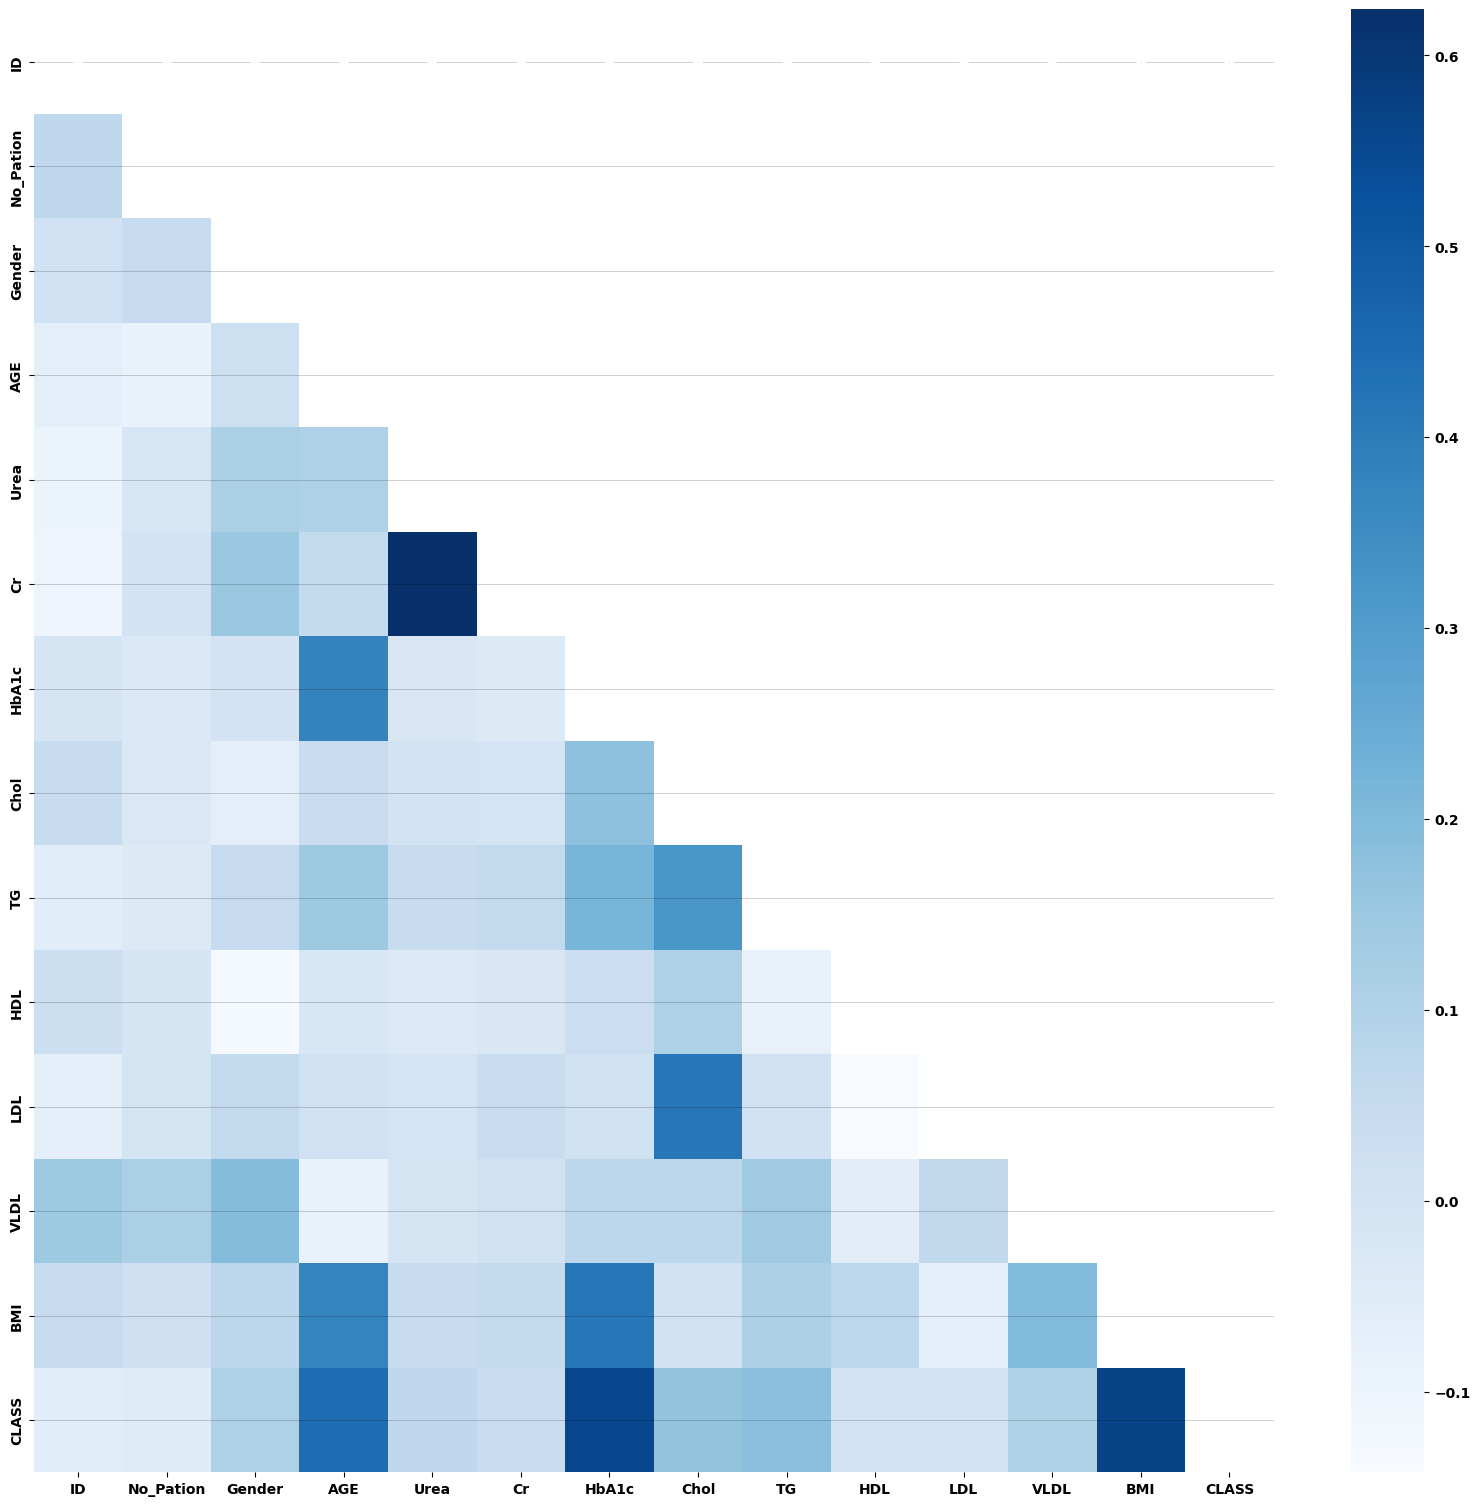

In [17]:
# code for heatmap
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize = (20,19))
sns.heatmap(corr, cmap= 'Blues', annot = True, mask = mask);

In [18]:
X = df.drop(columns=['CLASS'])
y = df['CLASS']

In [19]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [21]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

def is_sparse_pd_dtype(dtype):
    return isinstance(dtype, pd.SparseDtype)

# create preprocessing pipeline
preprocessor = make_column_transformer((ohe, cat_cols), (scaler, num_cols),remainder='drop', verbose_feature_names_out=False)

preprocessor._get_column_indices = lambda: [i for i, col in enumerate(preprocessor._columns) if is_sparse_pd_dtype(col.dtype)]

# Examine the results of all transformers
preprocessor.fit_transform(X_train,y_train).shape

(750, 13)

In [22]:
bagreg = BaggingRegressor(random_state = 42)
bagreg_pipe = make_pipeline(preprocessor, bagreg)
bagreg_pipe.fit(X_train, y_train)
evaluate_regression(bagreg_pipe, X_train, y_train, X_test, y_test)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Regression Model,0.0207,0.0452,0.0914,0.1752,0.9783,0.93


In [23]:
bagreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6888524D0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001F688C78B10>)],
                     verbose_feature_names_out=False)),
  ('baggingregressor', BaggingRegressor(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_select

In [29]:
bagreg_pipe = make_pipeline(preprocessor, BaggingRegressor())

param_grid = {'baggingregressor__n_estimators': [300,350.400],
              'baggingregressor__max_samples' : [80,90,100],
              'baggingregressor__max_features': [10,15,20]}
# Instaniate the gridsearch
gridsearch = GridSearchCV(bagreg_pipe, param_grid, n_jobs=-1, verbose=1)
# Fit the gridsearch on the training data
bag_gs = GridSearchCV(bagreg_pipe, param_grid).fit(X_train, y_train)

# Obtain the best paramters from the gridsearch
print(f'Best Params: {bag_gs.best_params_}')

C:\Users\arvin\anaconda3\envs\virtenv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
75 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\arvin\anaconda3\envs\virtenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\arvin\anaconda3\envs\virtenv\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arvin\anaconda3\envs\virtenv\Lib\site-packages\sklearn\pipeline

Best Params: {'baggingregressor__max_features': 10, 'baggingregressor__max_samples': 100, 'baggingregressor__n_estimators': 300}


In [30]:
evaluate_regression(bag_gs, X_train, y_train, X_test, y_test)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Regression Model,0.1091,0.1281,0.2354,0.2655,0.8558,0.8391


In [31]:
# creating random forest model and pipeline 
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Regression Model,0.017,0.0414,0.0658,0.1628,0.9887,0.9395


In [32]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6888524D0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001F688C78B10>)],
                     verbose_feature_names_out=False)),
  ('randomforestregressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_col

In [34]:
# creating pipeline for tuned model
rf_bagpipe = make_pipeline(preprocessor, RandomForestRegressor())

param_grid = {'randomforestregressor__n_estimators': [200,250,300],
              'randomforestregressor__max_samples' : [100,150,200],
              'randomforestregressor__max_features': [20,25,30],
              'randomforestregressor__min_samples_leaf': [1,2,3],
              'randomforestregressor__min_samples_split': [2,3,4]}
# Instaniate the gridsearch
gridsearch = GridSearchCV(rf_bagpipe, param_grid, n_jobs=-1, verbose=1)
# Fit the gridsearch on the training data
rf_gs = GridSearchCV(rf_bagpipe, param_grid).fit(X_train, y_train)

# Obtain the best paramters from the gridsearch
print(f'Best Params: {rf_gs.best_params_}')

Best Params: {'randomforestregressor__max_features': 25, 'randomforestregressor__max_samples': 200, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 250}


In [35]:
evaluate_regression(rf_gs, X_train, y_train, X_test, y_test)

,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Regression Model,0.0671,0.0859,0.1723,0.2114,0.9228,0.898
